In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes

color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

In [2]:
train_df = pd.read_csv("../data/spooky/train.csv")
test_df = pd.read_csv("../data/spooky/test.csv")
print("Number of rows in train dataset : ", train_df.shape[0])
print("Number of rows in test dataset : ", test_df.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


In [4]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 800x400 with 0 Axes>

In [6]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

In [7]:
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

train_df["num_stopwords"] = train_df["text"].apply(
    lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(
    lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

train_df["num_punctuations"] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df["num_punctuations"] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_75873/3789153480.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df['num_words'].loc[train_df['num_words'] > 80] = 80


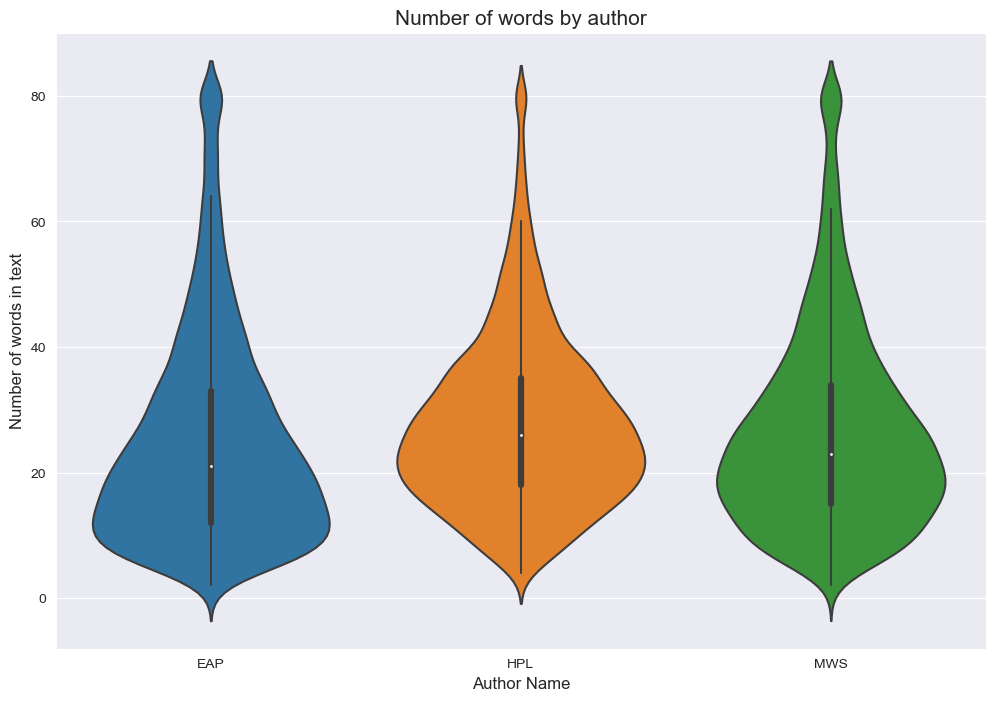

In [8]:
train_df['num_words'].loc[train_df['num_words'] > 80] = 80
plt.figure(figsize=(12, 8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_75873/3746044122.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df['num_punctuations'].loc[train_df['num_punctuations'] > 10] = 10


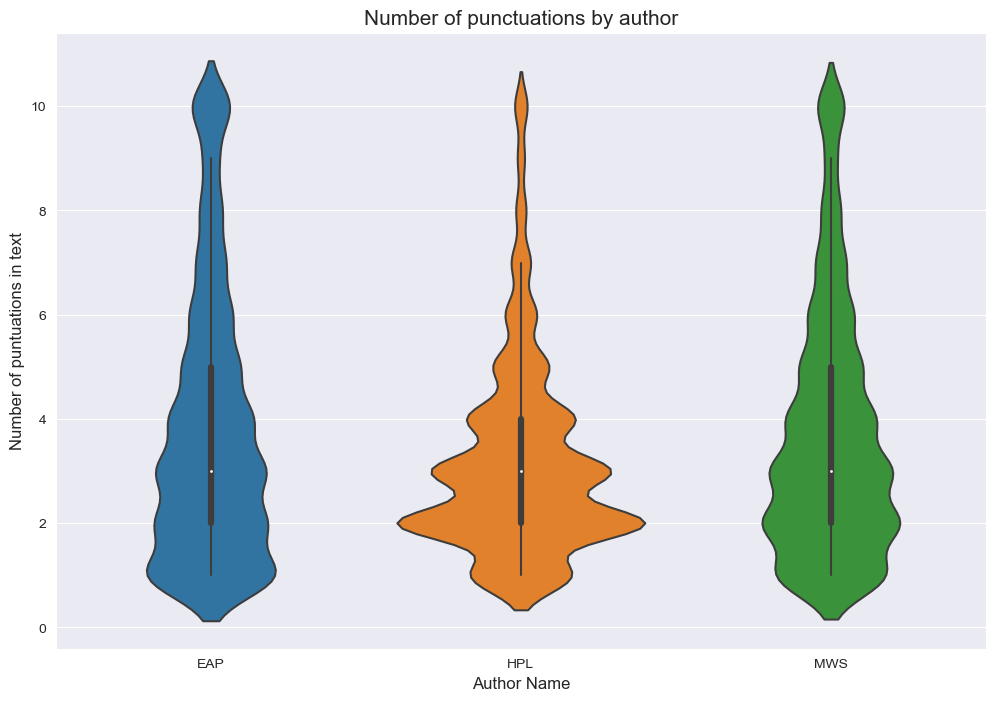

In [9]:
train_df['num_punctuations'].loc[train_df['num_punctuations'] > 10] = 10
plt.figure(figsize=(12, 8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

In [10]:
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop + ['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [11]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [(xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit=model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [12]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.09329	test-mlogloss:1.09383
[20]	train-mlogloss:1.03911	test-mlogloss:1.04788
[40]	train-mlogloss:1.02084	test-mlogloss:1.03499
[60]	train-mlogloss:1.00682	test-mlogloss:1.02350


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:01:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[80]	train-mlogloss:0.99652	test-mlogloss:1.01587
[100]	train-mlogloss:0.98860	test-mlogloss:1.01114
[120]	train-mlogloss:0.98176	test-mlogloss:1.00706
[140]	train-mlogloss:0.97542	test-mlogloss:1.00382
[160]	train-mlogloss:0.97068	test-mlogloss:1.00140
[180]	train-mlogloss:0.96592	test-mlogloss:0.99955
[200]	train-mlogloss:0.96182	test-mlogloss:0.99744
[220]	train-mlogloss:0.95786	test-mlogloss:0.99578
[240]	train-mlogloss:0.95450	test-mlogloss:0.99419
[260]	train-mlogloss:0.95138	test-mlogloss:0.99347
[280]	train-mlogloss:0.94808	test-mlogloss:0.99228
[300]	train-mlogloss:0.94534	test-mlogloss:0.99156
[320]	train-mlogloss:0.94258	test-mlogloss:0.99049
[340]	train-mlogloss:0.94043	test-mlogloss:0.99023
[360]	train-mlogloss:0.93797	test-mlogloss:0.98964
[380]	train-mlogloss:0.93557	test-mlogloss:0.98970
[400]	train-mlogloss:0.93333	test-mlogloss:0.98925
[420]	train-mlogloss:0.93111	test-mlogloss:0.98882
[440]	train-mlogloss:0.92903	test-mlogloss:0.98813
[460]	train-mlogloss:0.92713	tes

AttributeError: 'Booster' object has no attribute 'best_ntree_limit'

NameError: name 'model' is not defined

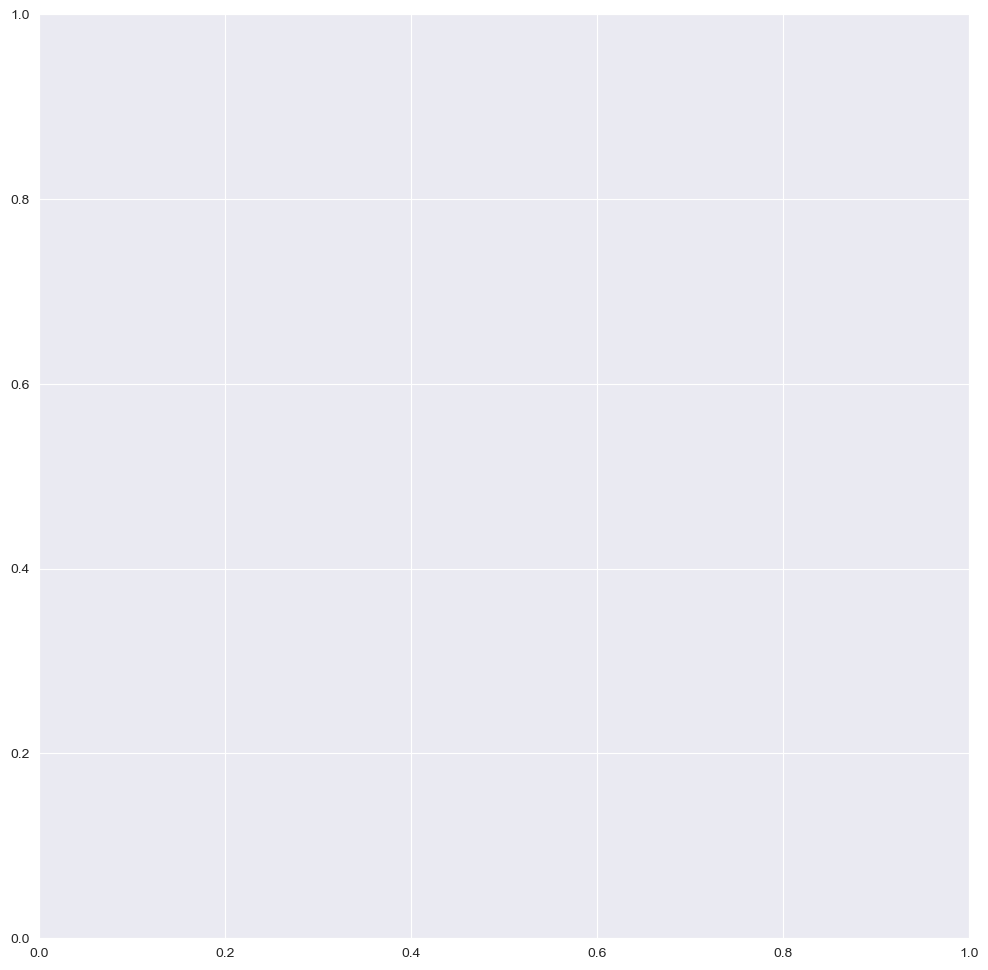

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [14]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [15]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [16]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.8422161983612853


In [17]:
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

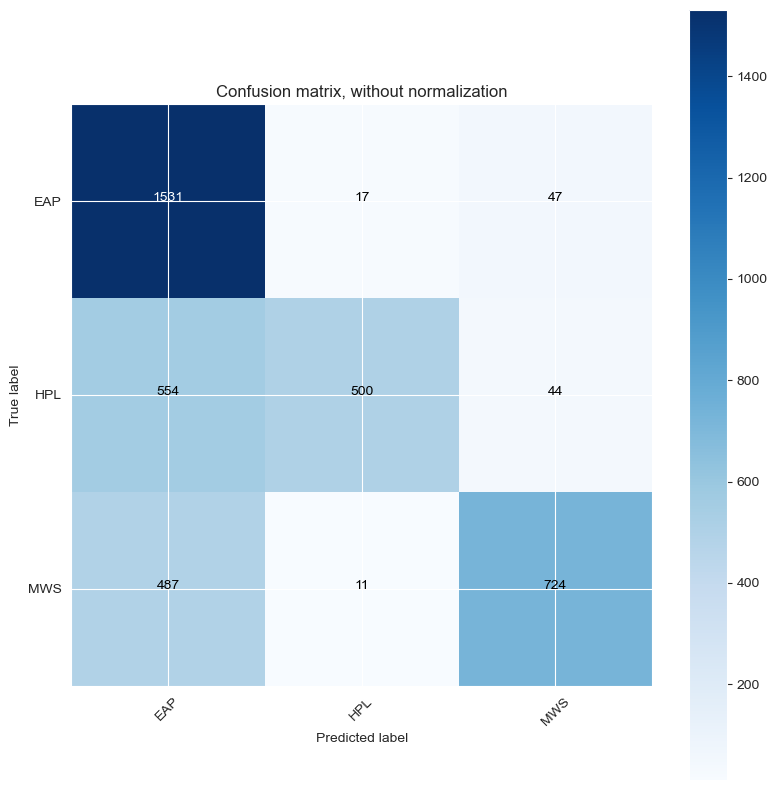

In [18]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

In [19]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_' + str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_' + str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [20]:
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1, 3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [21]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train_df["nb_cvec_eap"] = pred_train[:, 0]
train_df["nb_cvec_hpl"] = pred_train[:, 1]
train_df["nb_cvec_mws"] = pred_train[:, 2]
test_df["nb_cvec_eap"] = pred_full_test[:, 0]
test_df["nb_cvec_hpl"] = pred_full_test[:, 1]
test_df["nb_cvec_mws"] = pred_full_test[:, 2]

Mean cv score :  0.45091841616567424


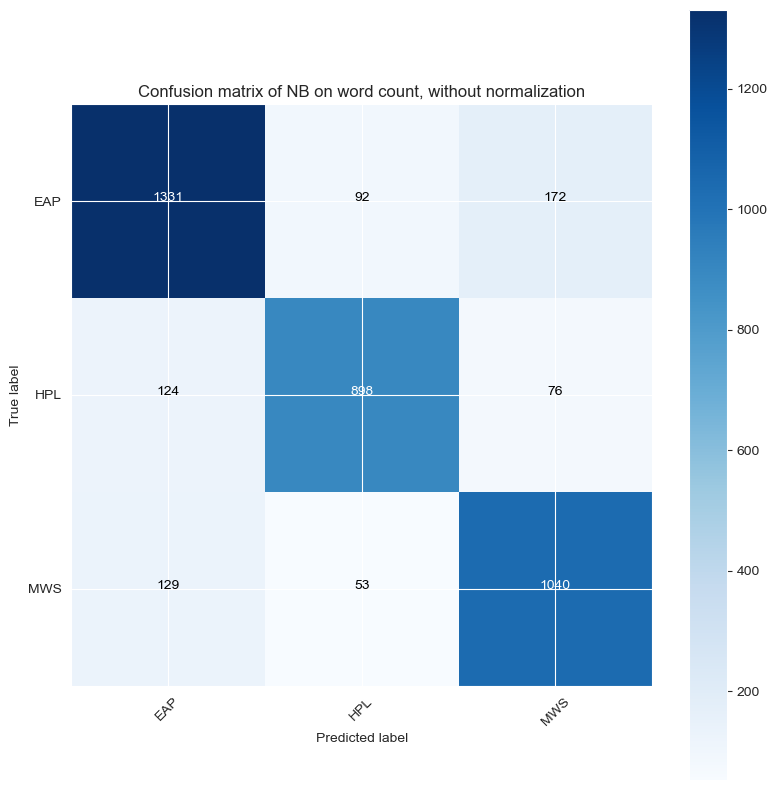

In [22]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

In [23]:
tfidf_vec = CountVectorizer(ngram_range=(1, 7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train_df["nb_cvec_char_eap"] = pred_train[:, 0]
train_df["nb_cvec_char_hpl"] = pred_train[:, 1]
train_df["nb_cvec_char_mws"] = pred_train[:, 2]
test_df["nb_cvec_char_eap"] = pred_full_test[:, 0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:, 1]
test_df["nb_cvec_char_mws"] = pred_full_test[:, 2]

Mean cv score :  3.8528982526171456


In [24]:
tfidf_vec = TfidfVectorizer(ngram_range=(1, 5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train_df["nb_tfidf_char_eap"] = pred_train[:, 0]
train_df["nb_tfidf_char_hpl"] = pred_train[:, 1]
train_df["nb_tfidf_char_mws"] = pred_train[:, 2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:, 0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:, 1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:, 2]

Mean cv score :  0.790415258947422


In [25]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_char_' + str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_' + str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [26]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop + ['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:1.00092	test-mlogloss:1.00061
[20]	train-mlogloss:0.41072	test-mlogloss:0.41494


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:05:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	train-mlogloss:0.34075	test-mlogloss:0.35164
[60]	train-mlogloss:0.31493	test-mlogloss:0.33437
[80]	train-mlogloss:0.29733	test-mlogloss:0.32444
[100]	train-mlogloss:0.28436	test-mlogloss:0.31900
[120]	train-mlogloss:0.27329	test-mlogloss:0.31532
[140]	train-mlogloss:0.26401	test-mlogloss:0.31335
[160]	train-mlogloss:0.25515	test-mlogloss:0.31018
[180]	train-mlogloss:0.24713	test-mlogloss:0.30819
[200]	train-mlogloss:0.24014	test-mlogloss:0.30732
[220]	train-mlogloss:0.23328	test-mlogloss:0.30678
[240]	train-mlogloss:0.22692	test-mlogloss:0.30540
[260]	train-mlogloss:0.22063	test-mlogloss:0.30494
[280]	train-mlogloss:0.21449	test-mlogloss:0.30464
[300]	train-mlogloss:0.20877	test-mlogloss:0.30472
[320]	train-mlogloss:0.20352	test-mlogloss:0.30487
[328]	train-mlogloss:0.20140	test-mlogloss:0.30480


AttributeError: 'Booster' object has no attribute 'best_ntree_limit'

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [27]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [3916, 3915]